In [29]:
import pyautogui
import cv2
from pynput.mouse import Button, Controller
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
import cv2
from PIL import Image 


mouse = Controller()

In [30]:
def get_locations():
    locations = {}
    messages = ["Put your mouse on the upper left of the canvas","Put your mouse on the bottom right of the canvas", " the colour palette", "click the box that has the hex colour", "click the ok box"]
    ans = "n"
    for i,x in enumerate(messages):
        print(x)
        ans = "n"
        while ans == "n":
            ans = input("Leave mouse in correct position. Are you ready? y/n")
    
        locations[i] = pyautogui.position()
        
    x_size = locations[1][0] - locations[0][0]
    y_size = locations[1][1] - locations[0][1]
    
    return locations, x_size, y_size
    
    

In [31]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image



In [32]:
def reduce_image(img_path,n_colors=32):
    base_img = cv2.imread(img_path)
    h,w,_ = base_img.shape
    ratio = h/w
    base_img_resized = cv2.resize(base_img,(int(y_size/ratio),int(y_size)))    
    base_img_resized = np.array(base_img_resized, dtype=np.float64) / 255
    w, h, d = original_shape = tuple(base_img_resized.shape)
    assert d == 3
    image_array = np.reshape(base_img_resized, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    codebook_random = shuffle(image_array, random_state=0)[:n_colors]
    labels_random = pairwise_distances_argmin(codebook_random,
                                              image_array,
                                              axis=0)

    img = recreate_image(kmeans.cluster_centers_, labels, w, h)
    img_new = cv2.cvtColor((img*255).astype(np.uint8),cv2.COLOR_RGB2BGR)
    return img_new

In [33]:
def get_hex(r, g, b):
    return '#%02x%02x%02x' % (r, g, b)

In [34]:
def get_hex_keys(img):
    unique_keys = {}

    for y in img_new:
        for x in y:
            hexx = get_hex(x[0],x[1],x[2])
            if not hexx in unique_keys.keys():
                unique_keys[hexx] = hexx
    return unique_keys

In [35]:
def change_colour(new_hex):
    #move to palette
    pyautogui.sleep(1)
    pyautogui.click(locations[2][0], locations[2][1])
    pyautogui.sleep(0.1)
    
    #click hex box
    pyautogui.click(locations[3][0], locations[3][1])
    pyautogui.sleep(0.1)
    
    #delete in box
    pyautogui.press('del', presses=8,interval=0.05)
    
    #write new one 
    pyautogui.write(new_hex, interval=0.05) 
    pyautogui.sleep(0.1)
    #press enter
    #pyautogui.press('return', presses=1,interval=0.05)
    #pyautogui.PAUSE = 0.2

    #click hex box
    pyautogui.click(locations[4][0], locations[4][1])
    pyautogui.sleep(0.1)

In [36]:
def draw_pos(startX,startY,posX,posY):
    #move to palette
    mouse.position = (int(startX+posX), int(startY+posY))
    pyautogui.sleep(0.0025)
    mouse.press(Button.left)
    pyautogui.sleep(0.008)
    mouse.release(Button.left)
    pyautogui.sleep(0.008)

In [37]:
def draw(img, keys, brush_size=2):    
    i = 0
    sorted_keys = sorted(list(unique_keys.keys()),key=lambda x: int(x.replace("#",""),16),reverse=True)
    for col in sorted_keys:
        change_colour(col.replace("#",""))
        for iy,y in enumerate(img):
            for ix,x in enumerate(y):
                if col == get_hex(x[0],x[1],x[2]):
                    draw_pos(locations[0][0], locations[0][1],ix*brush_size,iy*brush_size)
                    i += 1 
            pyautogui.sleep(0.01)

        pyautogui.sleep(0.5)

In [38]:
locations, x_size, y_size = get_locations()

Put your mouse on the upper left of the canvas


Ready? y/n y


Put your mouse on the bottom right of the canvas


Ready? y/n y


click the colour palette


Ready? y/n y


click the box that has the hex colour


Ready? y/n y


click the ok box


Ready? y/n y


In [39]:
img_new = reduce_image("dog.jpg")

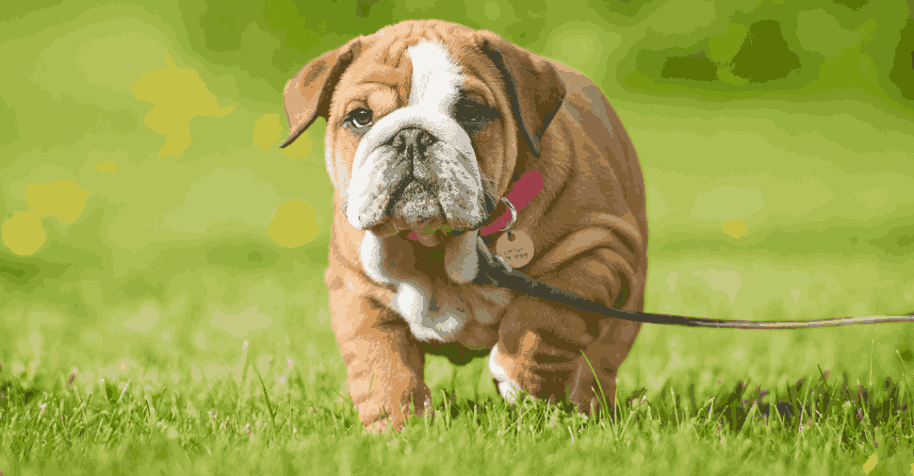

In [40]:
Image.fromarray(img_new)

In [41]:
unique_keys = get_hex_keys(img_new)

In [ ]:
draw(img_new,unique_keys,1)